# Predicting RUL of EV Batteries

In this project, we apply Data Analysis and Machine Learning techniques to predict the **Remaining Useful Life (RUL)** of EV Batteries. We have used the Battery Degradation dataset available at the [Prognostic Centre of Excellence (PCoE)](http://ti.arc.nasa.gov/project/prognostic-data-repository).

In [5]:
%%capture
!pip install pymatreader
!pip install simple-colors
PATH = '/content/drive/Shareddrives/DS 203 Course Project/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Importing required libraries for loading and storing the data from the matlab datafiles
from pymatreader import read_mat
import pandas as pd

# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import cmath 
import seaborn as sns
from simple_colors import *
sns.set()

### Data Description
4 Li-ion batteries were run through 3 operational profiles - charge, discharge and impedance at room temperature. 

1. Charging Profile - Each battery was charged a constant current (CC) of 1.5A till the battery voltage reached 4.2V. It was then charged in constant voltage (CV) mode until the charge current dropped to 20mA
2. Discharge Profile - Discharge was carried out at 2A CC until the battery voltage droped to 2.7V, 2.5V, 2.2V and 2.5V for each battery respectively
3. Impedance Profile - Used electrochemical impedance spectroscopy (EIS) sweeps from 0.1Hz to 5kHz

Each battery is subjected to 168 charge-discharge cycles which results in accelerated aging. The experiments were stopped once battery capacity diminished by 30% i.e. from 2 Ahr to 1.4 Ahr.

### Measurements
1. Charging fields
    * Battery terminal voltage (Volts) 
    * Battery output current (Amps)
    * Battery temperature (°C)
    * Current measured at charger (Amps)
    * Voltage measured at charger (Volts)
    * Measurement time stamps (secs)
    
    
2. Discharging fields
    * Battery terminal voltage (Volts) 
    * Battery output current (Amps)
    * Battery temperature (°C)
    * Current measured at load (Amps)
    * Voltage measured at load (Volts)
    * Measurement time stamps (secs)
    * **Battery capacity (Ahr) for discharge till 2.7V**

For ML model training and evaluation skip to the function definition linked below and run the required cells. <br>
[Link to function ```split_data```](#ML)

## Exploratory Data Analysis (EDA)

The data available is in a MATLAB structure and for ease of analysis, we use the [pymatreader](https://pypi.org/project/pymatreader/) module to load the data in Python. Data is separated into three dataframes for charge, discharge and impedance measurements respectively. 

Discharge data will be used for the purposes of RUL prediction while Impedance data will be used to explain the internal mechanisms resulting in battery degradation.

In [8]:
data = read_mat(PATH + 'B0005.mat')
df = pd.DataFrame(data['B0005']['cycle'])

In [9]:
df

,type,ambient_temperature,time,data
0,charge,24,"[2008.0, 4.0, 2.0, 13.0, 8.0, 17.921]","{'Voltage_measured': [3.873017221300996, 3.479..."
1,discharge,24,"[2008.0, 4.0, 2.0, 15.0, 25.0, 41.593]","{'Voltage_measured': [4.191491807505295, 4.190..."
2,charge,24,"[2008.0, 4.0, 2.0, 16.0, 37.0, 51.984]","{'Voltage_measured': [3.3250546568448542, 3.00..."
3,discharge,24,"[2008.0, 4.0, 2.0, 19.0, 43.0, 48.406]","{'Voltage_measured': [4.189773213846608, 4.188..."
4,charge,24,"[2008.0, 4.0, 2.0, 20.0, 55.0, 40.812]","{'Voltage_measured': [3.3526036599987754, 3.03..."
...,...,...,...,...
611,discharge,24,"[2008.0, 5.0, 27.0, 15.0, 52.0, 41.359]","{'Voltage_measured': [4.18482689434833, 4.1843..."
612,charge,24,"[2008.0, 5.0, 27.0, 17.0, 53.0, 59.765]","{'Voltage_measured': [3.7032033475672854, 3.33..."
613,discharge,24,"[2008.0, 5.0, 27.0, 20.0, 45.0, 42.125]","{'Voltage_measured': [4.201968615940368, 4.200..."
614,impedance,24,"[2008.0, 5.0, 27.0, 21.0, 34.0, 28.64]",{'Sense_current': [(839.7420654296875-31.55541...


Column **type** indicates what cycle is being experimented with. Column **ambient_temperature** contains the temperature in which the experiment was performed. 24 degrees is consistent with the dataset description. We can plot a histogram to check for variability in column **type** and **ambient_temperature**.

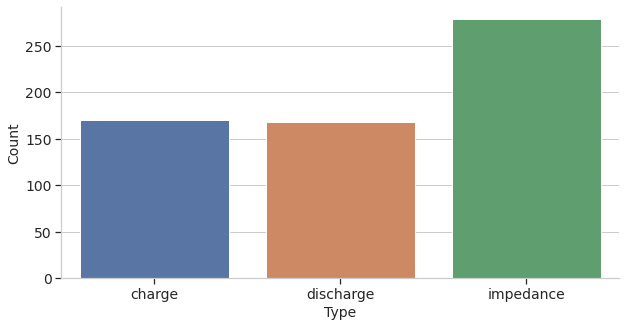

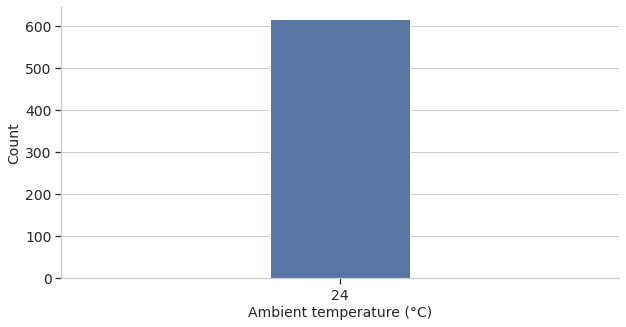

In [10]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
# Function to make a histogram plot for different columns in the data
def change_width(ax, new_value):
    '''
    Takes in a matplotlib axis object used for plotting a histogram/bar plot 
    and changes the width of the bars
    
    Arguments:
    ax -- matplotlib axis object
    new_value -- float, the desired width of the histogram bars
    '''

    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Changing the bar width
        patch.set_width(new_value)

        # Recentering the bar
        patch.set_x(patch.get_x() + diff * .5)

def plot_histogram(df, col, width = 0):
    '''
    Plots a histogram of the specified column of the dataframe

    Arguments:
    df -- pandas DataFrame object
    col -- string, label of a column in the "df" dataframe
    width -- float, if not equal to zero, the width of the bars in the histogram are modied
    '''

    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data = df, x = col, dodge = False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    # Change axis labels
    plt.ylabel('Count', fontsize=14)
    if col == 'ambient_temperature': plt.xlabel(col.capitalize().replace('_', ' ') + ' (°C)', fontsize=14)
    else: plt.xlabel(col.capitalize(), fontsize=14)
    # Change tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if width != 0: change_width(ax, width)
    plt.show()

plot_histogram(df=df, col='type')
plot_histogram(df=df, col='ambient_temperature', width = 0.25)

In column **type**, charge and discharge are evenly distributed which is consistent with the fact that the battery is being charged then discharged. Column **ambient_temperature** only contains 24°C which tells us the experimental conditions were consistent across multiple cycles. Note that ambient temperature is not the same as battery temperature. 

Column **time** contains the experiment start time in MATLAB date time format (YYYY-mm-dd-HH-mm-ss.s). It is clear that there was a time gap between the charge and discharge cycles during which the battery was rested. **Data** is the column of interest which contains information about each cycle in a list format. Although we will focus on discharge data to predict RUL, we will also plot the data in the charge and impedance cycles.

In [11]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    '''
    Takes cell number as input and return three dataframes containing the different types of data in the 
    corresponding .mat datafile

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18 (.mat files corresponding to the above mentioned cells are available)

    Returns:
    charge -- pandas DataFrame object, contains the data of type "charge" pulled from the specified .mat file
    discharge -- pandas DataFrame object, contains data of type "discharge"
    impedance -- pandas DataFrame object, contains data of type "impedance" 
    '''
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    data = read_mat(PATH + 'B00' + num + '.mat')
    df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [12]:
charge, discharge, impedance = split_data(cell_number = 5)

### Charging Cycle

We begin by plotting fields from the charging data for different cycles. This helps us understand the effects of battery degradation on charging performance.

In [13]:
# This function returns a dataframe containing the measurements and 
# the corresponding datatype stored depending on the "level". 

def get_dtypes(df, col2, level = 1, exclusions = []):
    '''
    Takes a dataframe and a column and returns a dataframe containing data types present in the specified column
    of the dataframe subject to conditions.

    Arguments:
    df -- pandas DataFrame object
    col2 -- string, label of a columns in the df dataframe
    level -- integer, specifies whether the function should return the data type of 
             the data in the column (level 1), or in the case that the data type is an array,
             return the data type of the data present within the array (level 2).
    exclusions -- list, if level is not 1, the function will treat the data in the 
                  column as arrays. This exclusions list will contain those rows
                  which have non-array entitities so that a level 2 analysis is
                  skipped for them. (These row labels are obtained after running
                  a level 1 analysis)
    
    Returns:
    pandas DataFrame object containing row names and corresponding data types
    '''
    col1 = 'Measurements'
    dtypes = []
    keys = []
    if level == 1: 
        for key in df.iloc[0]['data'].keys(): 
            keys.append(key)
            dtypes.append(str(type(df.iloc[0]['data'][key])))
    else:
        for key in df.iloc[0]['data'].keys(): 
            if not (key in exclusions):
                keys.append(key)
                dtypes.append(df.iloc[0]['data'][key].dtype)

    return pd.DataFrame((keys, dtypes), index = [col1, 'Datatype']).transpose()  

In [14]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(charge, 'Datatype', level = 1)

Measurements made with the type of data stored in it:


,Measurements,Datatype
0,Voltage_measured,<class 'numpy.ndarray'>
1,Current_measured,<class 'numpy.ndarray'>
2,Temperature_measured,<class 'numpy.ndarray'>
3,Current_charge,<class 'numpy.ndarray'>
4,Voltage_charge,<class 'numpy.ndarray'>
5,Time,<class 'numpy.ndarray'>


In [15]:
# All the data is in numpy arrays so we also print the datatype
# of the data in those arrays
get_dtypes(charge, 'Datatype', level = 2)

,Measurements,Datatype
0,Voltage_measured,float64
1,Current_measured,float64
2,Temperature_measured,float64
3,Current_charge,float64
4,Voltage_charge,float64
5,Time,float64


We observe that every dictionary value is a Python list consisting of time series data of datatype float. **Time** gives the instants at which a measurement was made.

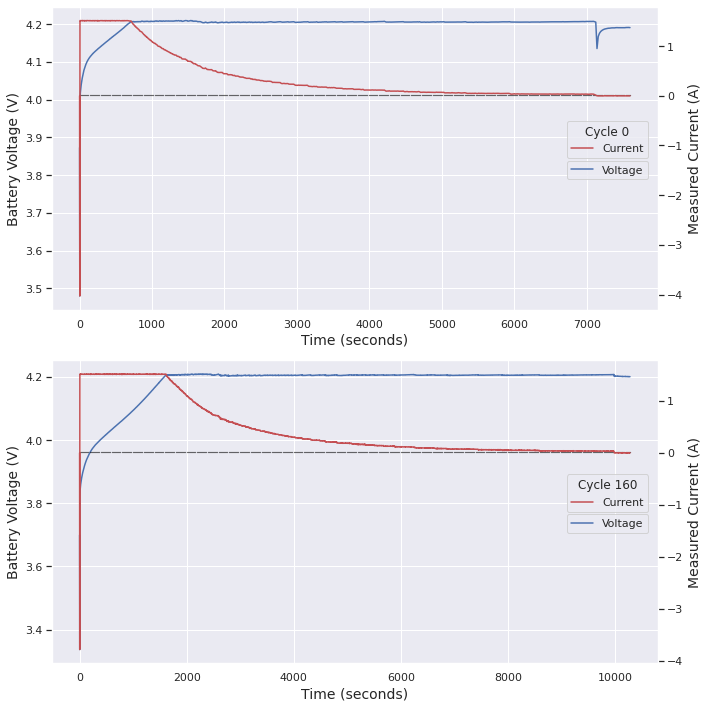

In [16]:
sns.set()
# Plot voltage and current variation for the charging cycle
time0 = charge.iloc[0]['data']['Time'] # Measurement time samples for each run
voltage0 = charge.iloc[0]['data']['Voltage_measured']
current0 = charge.iloc[0]['data']['Current_measured']

time160 = charge.iloc[160]['data']['Time'] # Measurement time samples for each run
voltage160 = charge.iloc[160]['data']['Voltage_measured']
current160 = charge.iloc[160]['data']['Current_measured']

voltages = {0: voltage0, 1: voltage160}
currents = {0: current0, 1: current160}
times = {0: time0, 1: time160}
cycles = {0: 0, 1: 160}

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes_2 = [0,0]

for i in [0,1]:
    axes[i].set_xlabel('Time (seconds)', fontsize=14)
    axes[i].set_ylabel('Battery Voltage (V)', fontsize=14)
    axes[i].plot(times[i], voltages[i], label = 'Voltage')
    axes[i].legend(loc = (0.85,0.43))

    axes_2[i] = axes[i].twinx()
    axes_2[i].set_ylabel('Measured Current (A)', fontsize=14)
    axes_2[i].plot(times[i], currents[i], label = 'Current', color = 'r')
    axes_2[i].grid(False)
    axes_2[i].scatter(np.linspace(0,times[i][-1],500), [0.02 for i in range(500)], s = 0.05, color = 'black')
    axes_2[i].legend(title = f'Cycle {cycles[i]}', loc = (0.85,0.5))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

From the above plots, we confirm that the battery is being charged at constant current upto 4.2V after which it is charged at constant voltage as the current measured falls. Comparing plots between different cycles, we observe that the battery takes longer to charge as it degrades which is indicated by a longer time for the battery voltage to reach 4.2V. We do not explicitly plot the current and voltage measured at the charger since we expect the plots to be similar to what we see above.

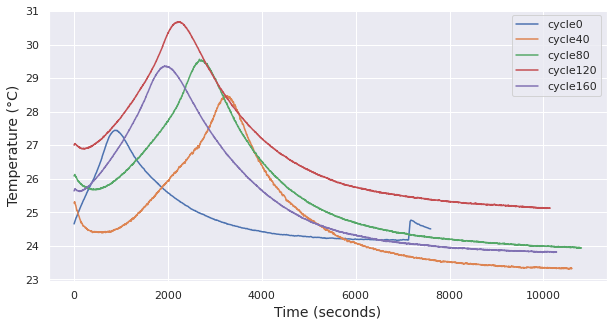

In [17]:
# Temperature variation during charging cycle
plt.figure(figsize=(10, 5))

cycles = [0, 40, 80, 120, 160]
for cycle in cycles:
  time = charge.iloc[cycle]['data']['Time']
  data = charge.iloc[cycle]['data']['Temperature_measured']

  plt.plot(time, data, label=f'cycle{cycle}', linewidth=1.5)
  plt.xlabel('Time (seconds)', fontsize=14)
  plt.ylabel('Temperature (°C)', fontsize=14)

plt.legend()
plt.show()

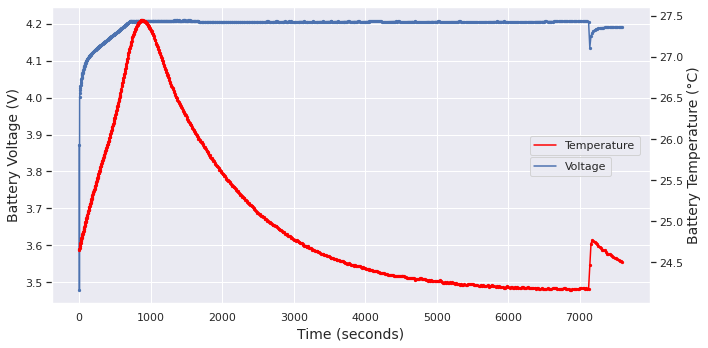

In [18]:
# Plotting temperature and discharge on the same plot
measured_voltage = charge.iloc[0]['data']['Voltage_measured']
measured_temperature = charge.iloc[0]['data']['Temperature_measured']
time = charge.iloc[0]['data']['Time']

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Battery Voltage (V)', fontsize=14)
ax1.plot(time, measured_voltage, label='Voltage')
ax1.scatter(time, measured_voltage, s=5)
ax1.legend(loc = (0.8,0.43))

ax2 = ax1.twinx() 

ax2.set_ylabel('Battery Temperature (°C)', fontsize=14)
ax2.plot(time, measured_temperature, color='red', label='Temperature')
ax2.scatter(time, measured_temperature, color='red', s=5)
ax2.legend(loc = (0.8,0.5))
ax2.grid(False)

fig.tight_layout() 
plt.show()

There doesn't seem to be a strong correlation between temperature in the charging cycle and battery degradation although the general trend is similar: temperature increases during the constant current phase and decreases in the constant voltage phase.

### Impedance Cycle

#### Background
Electrochemical impedance is measured by applying a small AC voltage over a wide-range of frequencies to a cell and measuring the current through it. The signal is kept small to ensure that the cell behaves pseudo-linearly. Impedance is a complex quantity and is specified by its magnitude and phase. 

From the dataset description, AC currents of frequencies between 0.1Hz and 5kHz are applied to estimate battery impedance. This is then used to obtain **Electrolytic** and **Charge-transfer** resistances at different stages of degradation. 

1. Electrolytic resistance is the resistance of the electrolyte
2. Charge-transfer resistance is the resistance faced by ions when they are transferred between different compounds in the cell

In [19]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(impedance, 'Type', level = 1)

Measurements made with the type of data stored in it:


,Measurements,Datatype
0,Sense_current,<class 'numpy.ndarray'>
1,Battery_current,<class 'numpy.ndarray'>
2,Current_ratio,<class 'numpy.ndarray'>
3,Battery_impedance,<class 'numpy.ndarray'>
4,Rectified_Impedance,<class 'numpy.ndarray'>
5,Re,<class 'float'>
6,Rct,<class 'float'>


_Sense_current_, _Battery_current_, _Current_ratio_, _Battery_impedance_, _Rectified_Impedance_ are numpy arrays while _Re_ (electrolytic resistance), _Rct_ (charge-transfer resistance) are float values. We also print the datatype of the numpy arrays to confirm that those quantities are complex numbers.

In [20]:
# Printing the datatype of each key which is an array.
# Re and Rct are of type float so they will be excluded
get_dtypes(impedance, 'Datatype', level = 2, exclusions = ['Re', 'Rct'])

,Measurements,Datatype
0,Sense_current,complex128
1,Battery_current,complex128
2,Current_ratio,complex128
3,Battery_impedance,complex128
4,Rectified_Impedance,complex128


We move on to plot _Sense_current_, _Battery_current_, _Current_ratio_, _Battery_impedance_, _Rectified_Impedance_ for different runs while _Re_, _Rct_ are plotted as a function of runs since these are floating-point numbers.

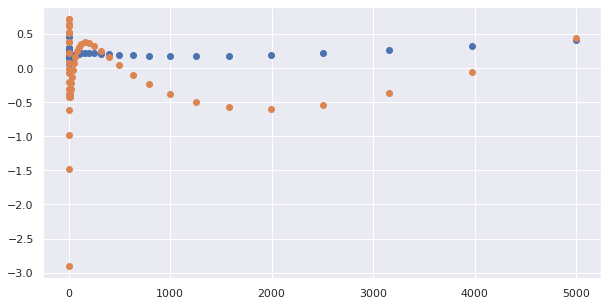

In [21]:
import cmath
test = np.logspace(start=np.log10(0.1), stop=np.log10(5000), num=48)
data = impedance.iloc[0]['data']['Battery_impedance']

plt.figure(figsize=(10, 5))
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(test, np.abs(data))
plt.scatter(test, [cmath.phase(data[i]) for i in range(len(data))])
# plt.scatter(test, np.ones(test.shape))

plt.show()

In [22]:
# Helper function for plotting impedance characteristics
def plot_impedance_characteristics(df, feature, runs=[0, 80, 160, 240], log_scale=False):
    '''
    Takes dataframe (containing impedance data), feature, and a list of runs as input and plots 
    the data stored in it. Since the function is specifically for impedance data, and that has
    data stored in complex format, the graph of the magnitudes is plotted.

    Arguments:
    df -- pandas DataFrame object, should contain impedance data conforming to the required format
    feature -- string, the data corresponding to this feature will be plotted
    runs -- list, plots of the specified feature will be made for all the runs specified in this list
    log_scale -- bool, specifies whether the axes should be log-scaled
    '''
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    if log_scale:
        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[1].set_xscale('log')
    # Plotting the magnitude for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_magnitude = np.abs(data)

        axes[0].plot(data_magnitude, label=f'run{run}')
        axes[0].legend()

    axes[0].set_title(f'{feature.replace("_", " ").title()} Magnitude plot', fontsize=16)

    # Plotting the phase for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_phase = [cmath.phase(data[i]) for i in range(len(data))]

        axes[1].plot(data_phase, label=f'run{run}')
        axes[1].legend()

    axes[1].set_title(f'{feature.replace("_", " ").title()} Phase plot', fontsize=16)
    plt.show()

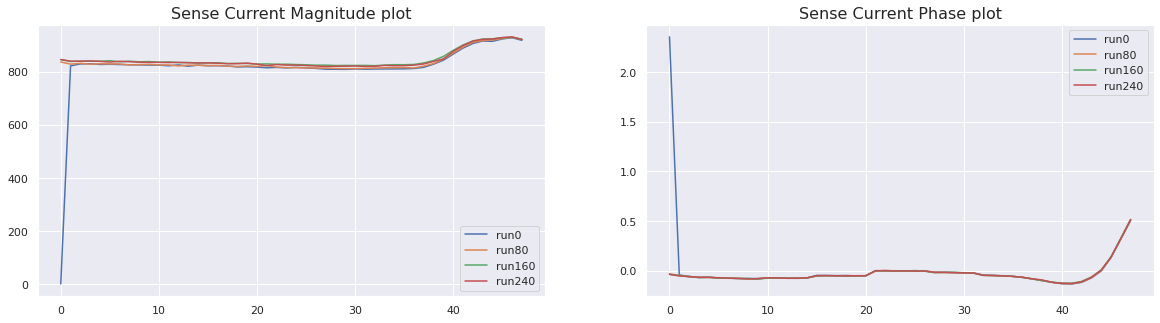

In [23]:
plot_impedance_characteristics(impedance, 'Sense_current')

From the sense current magnitude plot, the magnitude of current applied for different frequencies is almost constant across different runs which is expected since measurements must be made under similar conditions. We repeat the above procedure for **battery current**.

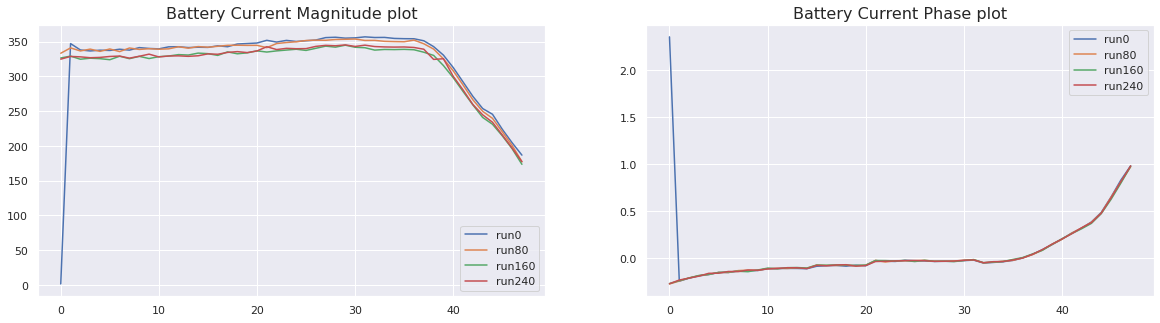

In [24]:
plot_impedance_characteristics(impedance, 'Battery_current')

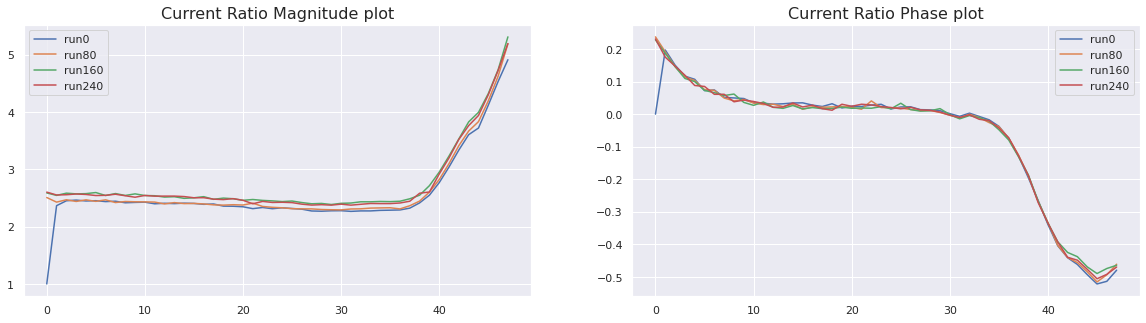

In [25]:
plot_impedance_characteristics(impedance, 'Current_ratio')

So far there doesn't seem to be any visible trend in battery internal parameters as the battery degrades over time.

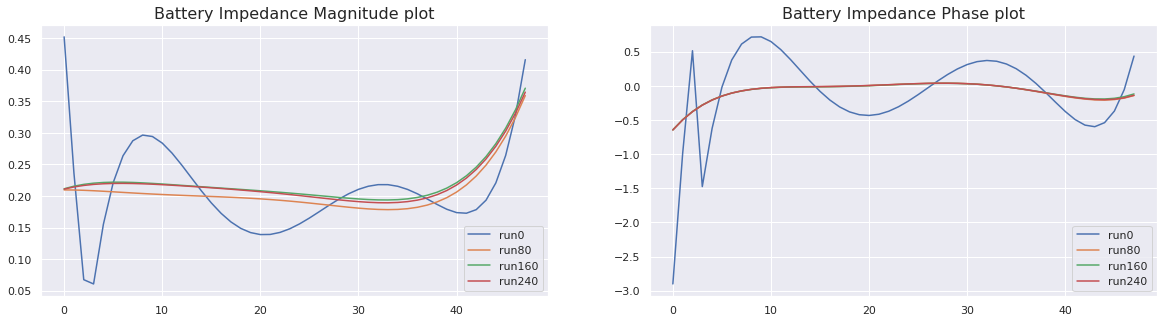

In [26]:
plot_impedance_characteristics(impedance, 'Battery_impedance')

From the Battery Impedance plots, we observe that with time, the impedance stabilises and doesn't oscillate.

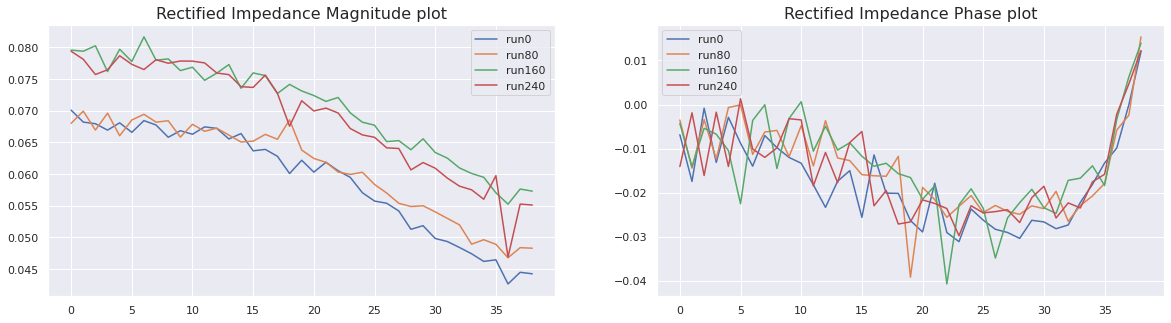

In [27]:
plot_impedance_characteristics(impedance, 'Rectified_Impedance')

Although the phase plot doesn't have any pertinent features, the magnitude plot shows an increase in rectified impedance as the battery deteriorates.

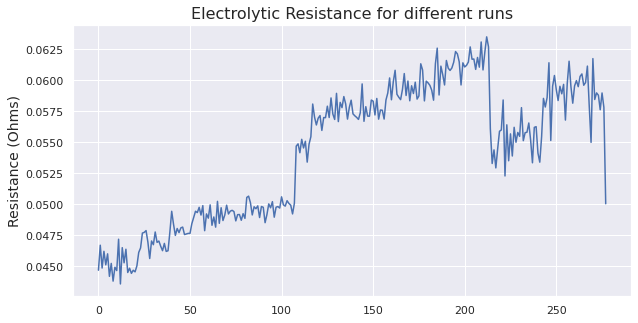

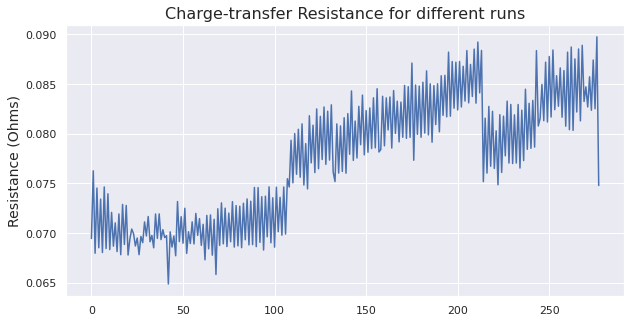

In [28]:
# Helper function to plot resistances as a function of runs
def plot_resistance(df, key):
    '''
    Takes a dataframe (containing impedance data) and key as input and plots the data corresponding
    to the key.

    Arguments:
    df -- pandas DataFrame object, should contain impedance data conforming to the required format
    key -- string, should be one of "Re" or "Rct". The function scans the complete dataframe for 
           the required key (each row in the dataframe corresponds to one run, and each run contains 
           one value for "Re" and "Rct")
    '''
    resistance = [impedance.iloc[i]['data'][key] for i in range(len(impedance))]

    labels = {
        'Re': 'Electrolytic Resistance',
        'Rct': 'Charge-transfer Resistance'
    }

    plt.figure(figsize=(10, 5))
    plt.title(f'{labels[key]} for different runs', fontsize=16)
    plt.ylabel('Resistance (Ohms)', fontsize=14)
    plt.plot(resistance)

    plt.show()

# Plot the electrolytic and charge-transfer resistance for different runs
plot_resistance(impedance, 'Re')
plot_resistance(impedance, 'Rct')

Instead of directly trying to analyse Impedance, we adopt a different approach where we try and understand **when** has this data been collected (so far we had been referring to different instants as _runs_ but let's try to understand what this means)

In [29]:
impedance.index # Print indices for impedance measurements in the original data

Int64Index([ 40,  42,  44,  46,  48,  50,  52,  54,  56,  58,
            ...
            594, 596, 598, 600, 602, 604, 606, 608, 610, 614],
           dtype='int64', length=278)

We 'zoom' in to different points in the dataframe around the impedance measurements.

In [30]:
display(df[35:50])

,type,ambient_temperature,time,data
35,charge,24,"[2008.0, 4.0, 5.0, 15.0, 42.0, 11.531]","{'Voltage_measured': [3.3967166797066484, 3.09..."
36,discharge,24,"[2008.0, 4.0, 5.0, 18.0, 39.0, 25.218]","{'Voltage_measured': [4.188779799856791, 4.188..."
37,charge,24,"[2008.0, 4.0, 5.0, 19.0, 46.0, 36.125]","{'Voltage_measured': [3.3869430085009946, 3.08..."
38,discharge,24,"[2008.0, 4.0, 5.0, 22.0, 46.0, 35.484]","{'Voltage_measured': [4.189272591516219, 4.188..."
39,charge,24,"[2008.0, 4.0, 18.0, 17.0, 34.0, 22.89]","{'Voltage_measured': [3.5795499179382677, 3.23..."
40,impedance,24,"[2008.0, 4.0, 18.0, 20.0, 55.0, 29.859]","{'Sense_current': [(-1+1j), (820.6094970703125..."
41,discharge,24,"[2008.0, 4.0, 18.0, 21.0, 10.0, 19.796]","{'Voltage_measured': [4.187614060563439, 4.186..."
42,impedance,24,"[2008.0, 4.0, 18.0, 22.0, 39.0, 16.312]","{'Sense_current': [(-1+1j), (656.5957641601562..."
43,charge,24,"[2008.0, 4.0, 18.0, 22.0, 53.0, 58.343]","{'Voltage_measured': [3.389085680145772, 3.068..."
44,impedance,24,"[2008.0, 4.0, 19.0, 2.0, 14.0, 27.015]","{'Sense_current': [(-1+1j), (809.5048217773438..."


We observe that separate impedance measurements are made _after_ charging and _after_ discharging the battery. Let us compare the impedance characteristics after charging and discharing the battery at a particular point.

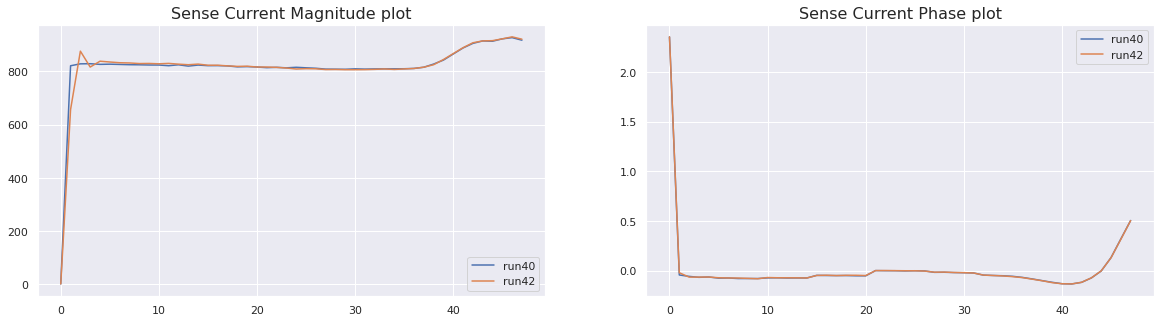

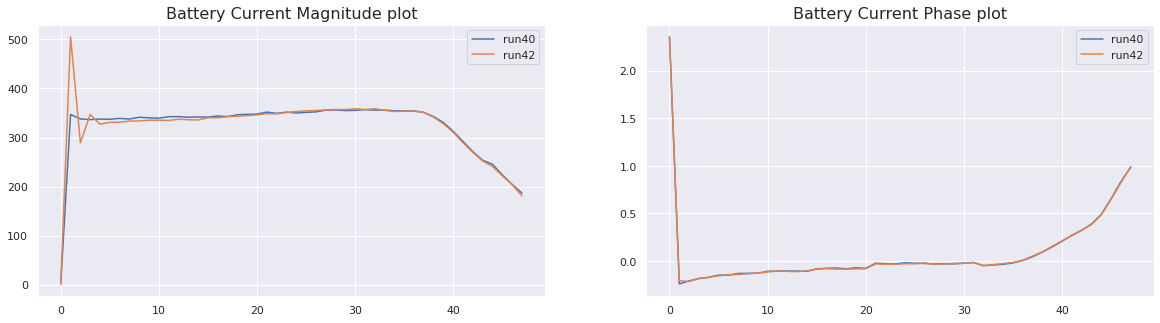

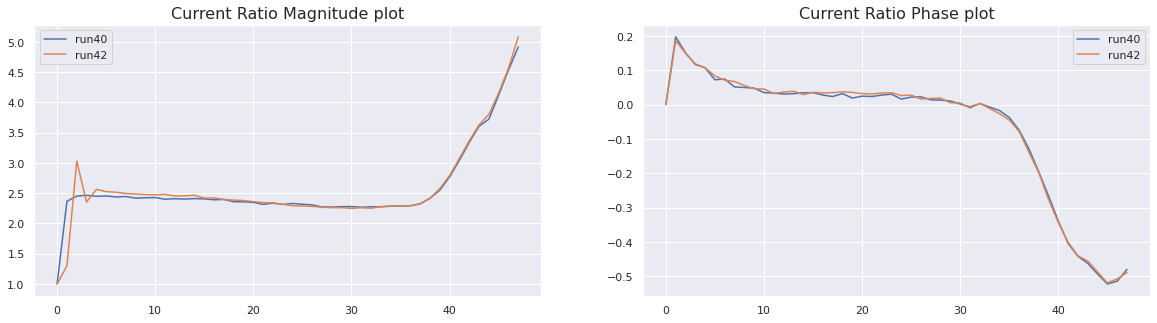

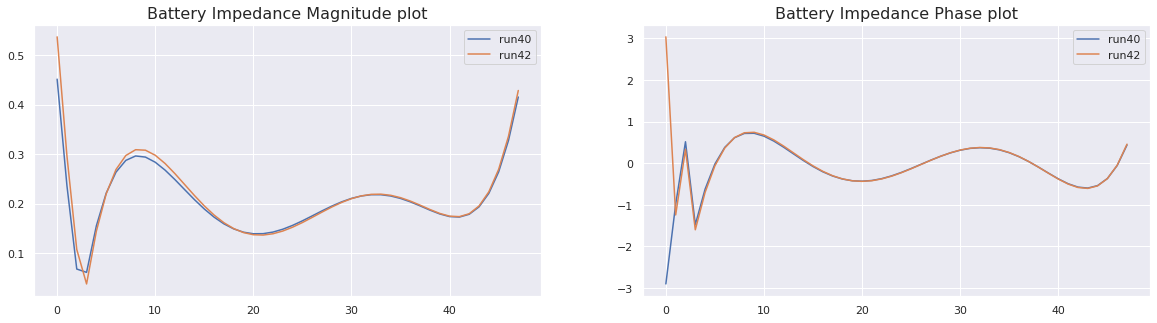

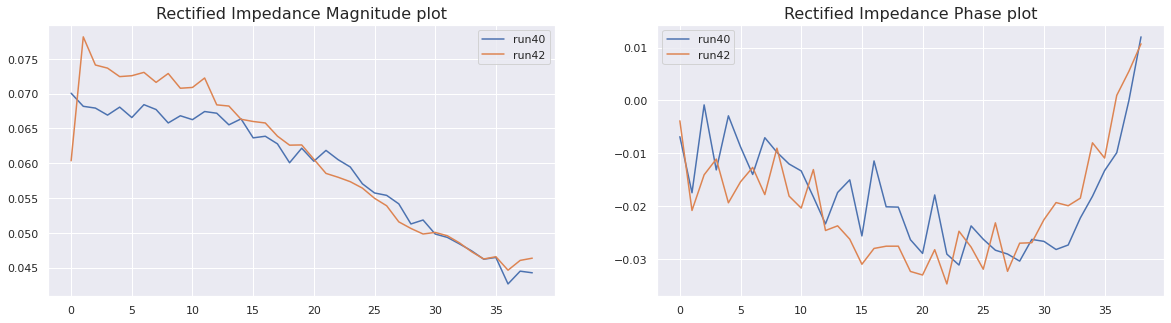

In [31]:
# 40 is an impedance measurement after charging
# 42 is an impedance measurement after discharging
runs = [40, 42] 
keys = ['Sense_current', 'Battery_current', 'Current_ratio', 
        'Battery_impedance', 'Rectified_Impedance']
for key in keys:
  plot_impedance_characteristics(df, key, runs, log_scale=False) # Plotting the parameters in keys

Nothing seems to stand out from the plots although the electrolytic and charge-transfer resistances have lowered after discharging.

We also experiment with **Nyquist plots** for Battery Impedance and Rectified Impedance. In a Nyquist plot, The real and imaginary parts of a complex number are plotted along separate axes.

In [32]:
def plot_nyquist(df, feature, runs=[0, 80, 160, 240]):
    '''
    Function to make a Nyquist plot for battery and rectified impedance. In a 
    Nyquist plot, the real and imaginary parts are plotted against each other.

    Arguments:
    df -- pandas DataFrame object, should contain impedance data conforming to the required format
    feature -- string, the data corresponding to this feature will be plotted
    runs -- list, plots of the specified feature will be made for all the runs specified in this list 
    '''
    plt.figure(figsize=(10, 5))
    # Plotting the magnitude for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_real = [data[i].real for i in range(len(data))]
        data_imag = [-data[i].imag for i in range(len(data))]

        plt.scatter(data_real, data_imag, label=f'run{run}')
        plt.legend()

    plt.title(f'{feature.replace("_", " ").title()} Nyquist plot', fontsize=16)
    plt.xlabel('Re(Z) Ω', fontsize=14)
    plt.ylabel('-Im(Z) Ω', fontsize=14)
    plt.show()

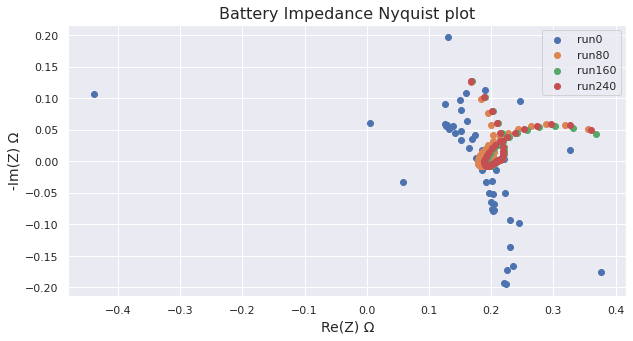

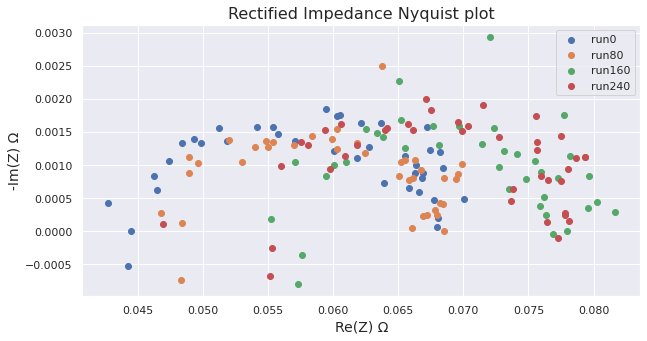

In [33]:
plot_nyquist(impedance, feature='Battery_impedance', runs=[0, 80, 160, 240]) # Plotting the parameters in keys
plot_nyquist(impedance, feature='Rectified_Impedance', runs=[0, 80, 160, 240]) # Plotting the parameters in keys

One takeaway from the above is that the battery resistance seems to be increasing as it discharges.

### Discharge Cycle

We start by plotting features from the discharge cycle to understand the effects of battery degradation. We do not plot the voltage and current at the load because voltage and current measured at the battery give us an indication of the general trend.

In [34]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(discharge, 'Datatype', level = 1)

Measurements made with the type of data stored in it:


,Measurements,Datatype
0,Voltage_measured,<class 'numpy.ndarray'>
1,Current_measured,<class 'numpy.ndarray'>
2,Temperature_measured,<class 'numpy.ndarray'>
3,Current_load,<class 'numpy.ndarray'>
4,Voltage_load,<class 'numpy.ndarray'>
5,Time,<class 'numpy.ndarray'>
6,Capacity,<class 'float'>


Except _capacity_, all features are time series data and will be plotted for different discharge cycles. We also plot capacity as a function of discharge cycles. Note that Battery capacity has been provided at the end of discharge for that particular cycle.

In [35]:
# Printing the datatype of each key which is an array.
# Capacity is of type float so it will be excluded
get_dtypes(discharge, 'Datatype', level = 2, exclusions = ['Capacity'])

,Measurements,Datatype
0,Voltage_measured,float64
1,Current_measured,float64
2,Temperature_measured,float64
3,Current_load,float64
4,Voltage_load,float64
5,Time,float64


In [36]:
from matplotlib.patches import Rectangle
# This function plots the data of specified type (voltage, current or temperature)
# for the cycle numbers specified by "cycle_list" argument
sns.set()
def dc_cycle_plots(cell_number, cycle_list, type, figsize = (10,5), only_scatter = False, zoom_beginning_range = None):
    '''
    Creates plots of the specified type of data for the specified number of cycles for the specified cell number.

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18
    cycle_list -- list, contains the required cycle numbers for which the plots should be made
    type -- string, can be one of "voltage", "current", "temperature". The plots for the 
            corresponding type will be created after the discharge data is extracted for the 
            specified cell number.
    figsize -- tuple, specifies the size of the plot
    only_scatter -- bool, set to True if only the scatter plot is desired
    zoom_beggining_range -- integer, if this argument is not "None", a small subplot will be 
                            created for the data sliced from the first value to the value specified.
                            In addition to the subplot, a rectangle will also be created around
                            the initial part of the graph.
                            !! for type = "voltage" only !!
    '''
    _, discharge, _= split_data(cell_number)

    labels = {'voltage': 'Battery terminal voltage (V)',
              'current': 'Battery output current (A)',
              'temperature': 'Battery temperature (°C)'}
    type_ = type.capitalize() + '_measured'

    fig, ax0 = plt.subplots(1, 1, figsize = figsize)

    for cycle in cycle_list:
        time_data = discharge.iloc[cycle]['data']['Time']   # List of times obtained from the "discharge" dataframe
        type_data = discharge.iloc[cycle]['data'][type_]    # Data of the type specified, obtained from the "discharge" dataframe

        if not only_scatter: ax0.plot(time_data, type_data, label = f"cycle {cycle}")
        ax0.scatter(time_data, type_data, s = 5)

    plt.title(f"{type.capitalize()} Measured for cell number {cell_number}", fontsize = 16)
    plt.xlabel("Time (seconds)", fontsize = 14)
    plt.ylabel(labels[type], fontsize = 14)
    plt.legend()

    if zoom_beginning_range != None and type == 'voltage':
        ax0.add_patch(Rectangle((-50,3.9), 200, 0.4, edgecolor = "black", facecolor = "none"))
        ax0.text(200, 4.1, "Initial Sharp Decrease")
        sns.reset_orig()
        ax = fig.add_axes([0.17, 0.3, 0.2, 0.2])
        for cycle in cycle_list:
            time_data = discharge.iloc[cycle]['data']['Time'][:zoom_beginning_range]   # List of times obtained from the "discharge" dataframe
            type_data = discharge.iloc[cycle]['data'][type_][:zoom_beginning_range]    # Data of the type specified, obtained from the "discharge" dataframe

            ax.plot(time_data, type_data)
            ax.scatter(time_data, type_data, s = 1)
            ax.set_xlabel("Magnified portion")
            ax.grid(False)
        sns.set()

    plt.show()

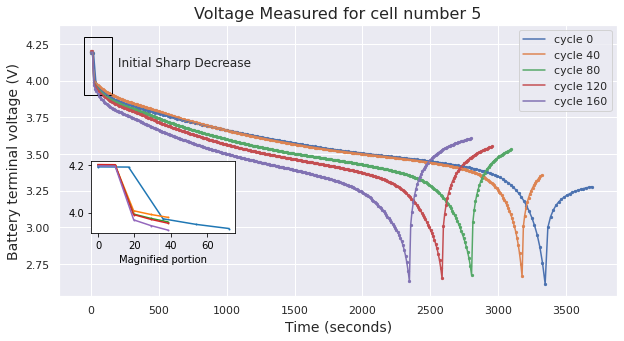

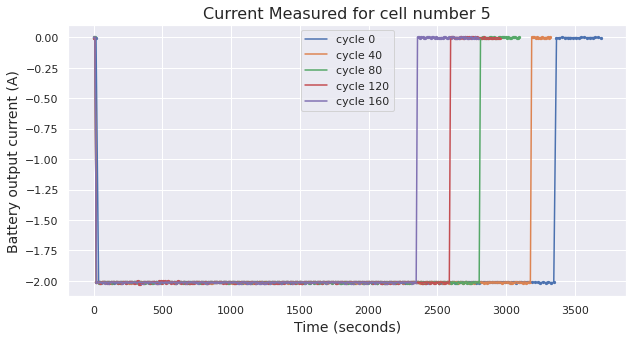

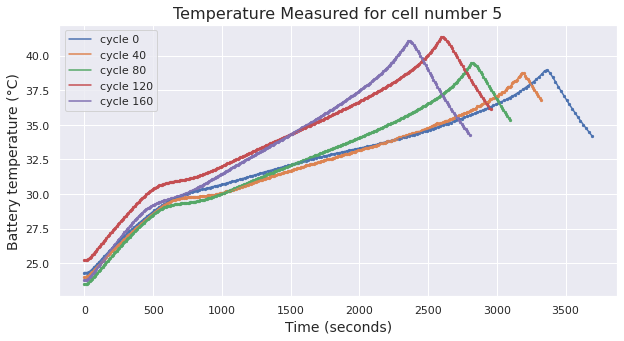

In [37]:
cycles = [0, 40, 80, 120, 160]
figsize = (10,5)

# Observing that voltage has an initial drop, we magnify the initial sharp decrease in voltage measured
dc_cycle_plots(5, cycles, 'voltage', figsize = figsize, only_scatter = False, zoom_beginning_range = 5) 

dc_cycle_plots(5, cycles, 'current', figsize = figsize, only_scatter = False)
dc_cycle_plots(5, cycles, 'temperature', figsize = figsize, only_scatter = False)

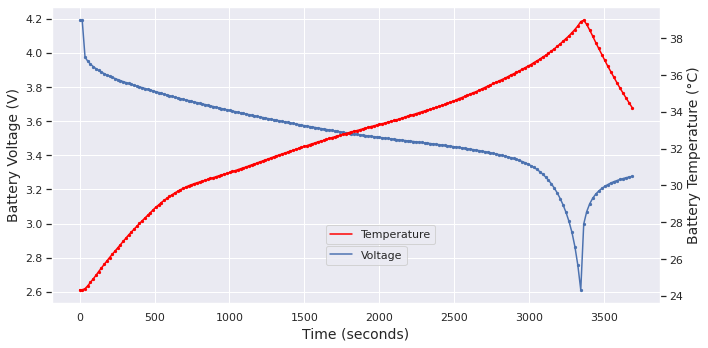

In [38]:
# Plotting temperature and discharge on the same plot
measured_voltage = discharge.iloc[0]['data']['Voltage_measured']
measured_temperature = discharge.iloc[0]['data']['Temperature_measured']
time = discharge.iloc[0]['data']['Time']

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Battery Voltage (V)', fontsize=14)
ax1.plot(time, measured_voltage, label='Voltage')
ax1.scatter(time, measured_voltage, s=5)
ax1.legend(loc = (0.45,0.13))

ax2 = ax1.twinx() 

ax2.set_ylabel('Battery Temperature (°C)', fontsize=14)
ax2.plot(time, measured_temperature, color='red', label='Temperature')
ax2.scatter(time, measured_temperature, color='red', s=5)
ax2.grid(False)
ax2.legend(loc = (0.45,0.2))

fig.tight_layout() 
plt.show()

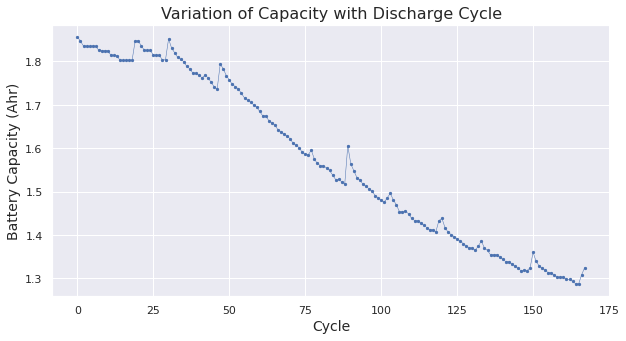

In [39]:
# Plotting capacity as a function of discharge cycles
capacity = [discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))]

plt.figure(figsize=(10, 5))
plt.title('Variation of Capacity with Discharge Cycle', fontsize=16)
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('Battery Capacity (Ahr)', fontsize=14)

plt.plot(capacity, linewidth=0.5)
plt.scatter(np.arange(0, len(capacity)), capacity, s=5)
plt.show()

We highlight some of the important features in the discharge characteristics. 

1. Voltage Measured 

We can divide the plot into 4 portions: sharp decrease in the start which appears to be linear followed by a region with reduced slope upto the knee point. An exponential-like drop follows after which the experiment is stopped. The battery voltage begins to rise after this point due to the diffusion of acid from the electrolyte to the plates. The initial steep decline is due to the internal battery impedance on application of the load current. The slope of this portion can be used to estimate this impedance and is consistent with the fact that the battery impedance increases as the battery degrades.

![Voltage graph](https://drive.google.com/uc?export=view&id=1-IxO0kEIyrUpTjVplSP5c0YfwcFulqIk)


2. Temperature Measured

We can divide the plot into 3 portions: steep temperature rise upto a knee point, rise in temperature with a reduced slope till the peak temperature and finally a fall. The fall is due to removal of the load allowing the battery to return to ambient temperature. The first portion can be attributed to a sudden application in the load current. 

The regions visualized taking one cycle's voltage and temperature profiles as an example are given below.

![Temperature graph](https://drive.google.com/uc?export=view&id=1FCix6-mjfgR8LVv5Ih2Iqmxec9F4WIkL)

We observe that as the battery deteriorates, it takes less time for the battery to discharge. We also observe that the maximum temperature achieved by the battery increases monotonically as the battery discharges. As the battery degrades, it takes less time for the battery to reach its maximum temperature.

We observe that the discharge has been stopped once the battery voltage drops to 2.6-2.7V. This is because the [Discharge Cutoff Voltage](https://en.wikipedia.org/wiki/Cutoff_voltage) for an 18650 Li-ion battery is 3.0V. The experiment has pushed the batteries beyond this to accelerate degradation effects as mentioned in the dataset description.

### Predicting RUL

We use an indirect approach to estimate RUL. **Battery Capacity** is estimated using measurements made in the discharge cycle. Although capacity can be measured directly, it is infeasible while the electric vehicle is running. On the other hand, voltage and current measurements are easy to make.

We begin by pre-processing the data for feature extraction.
Features extracted:
1. Time instants at which battery voltage hits specified voltage values between 2.7V and 4V
2. Time at which battery is discharged and the load current is stopped
3. Maximum temperature attained by the battery during discharge
4. Time at which battery attains maximum temperature

<a name="ML"></a>

In [76]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    '''
    Takes cell number as input and return three dataframes containing the different types of data in the 
    corresponding .mat datafile

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18 (.mat files corresponding to the above mentioned cells are available)

    Returns:
    charge -- pandas DataFrame object, contains the data of type "charge" pulled from the specified .mat file
    discharge -- pandas DataFrame object, contains data of type "discharge"
    impedance -- pandas DataFrame object, contains data of type "impedance" 
    '''
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    data = read_mat(PATH + 'B00' + num + '.mat')
    df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [77]:
print(split_data.__doc__)


    Takes cell number as input and return three dataframes containing the different types of data in the 
    corresponding .mat datafile

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18 (.mat files corresponding to the above mentioned cells are available)

    Returns:
    charge -- pandas DataFrame object, contains the data of type "charge" pulled from the specified .mat file
    discharge -- pandas DataFrame object, contains data of type "discharge"
    impedance -- pandas DataFrame object, contains data of type "impedance" 
    


In [63]:
# This function performs the major preprocessing of the data, by picking out the data values 
# which will be used for training out of the complete available data
def preprocessing(cell_number, voltage_splits = 16):
    '''
    Extracts features and labels from the data from the specified cell number 
    and returns them as numpy arrays

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18
    voltage_splits -- integer, specifies number of values the interval of voltages
                      [2.7, 4] should be split into
    
    Returns:
    x -- numpy array, contains the feature data. The required features are extracted
         from the discharge data of the specified cell number.
    y -- numpy array, contains the labels corresponding to the features in "x"
    '''
    _, discharge, _ = split_data(cell_number)
    voltages = np.linspace(2.7, 4, voltage_splits)
    
    # features0 stores the Times at which terminal voltage is 2.7, ..., 4
    # features1 stores the Time to reach minimum terminal voltage
    # feature2 stores the Maximum temperature
    # feature3 stores the Time to reach maximum temperature
    
    feature0, feature1, feature2, feature3 = [], [], [], []
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']                       # Getting time data from the discharge dataframe
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']        # Getting voltage data
        temp_data = discharge.iloc[i]['data']['Temperature_measured']       # Getting temperature data

        times = []
        for j in range(voltage_splits):
            time_for_closest_voltage = time_data[np.argmin(np.abs(voltage_data - voltages[j]))]         # time at which the reading stored in "voltage_data" is closest 
            times.append(time_for_closest_voltage)                                                      # to one of the values in the "voltages" array
        
        feature0 = feature0 + [times]
        feature1.append(time_data[np.argmin(voltage_data)])
        feature2.append(np.max(temp_data))

        time_for_max_temp = time_data[np.argmax(temp_data)]                 # time at which temperature reaches its maximum value
        feature3.append(time_for_max_temp)

    # Using list comprehension: 
    # feature0 = [[discharge.iloc[i]['data']['Time'][np.argmin(np.abs(discharge.iloc[i]['data']['Voltage_measured'] - voltages[j]))] for j in range(len(voltages))] for i in range(len(discharge))]
    # feature1 = [discharge.iloc[i]['data']['Time'][np.argmin(discharge.iloc[i]['data']['Voltage_measured'])] for i in range(len(discharge))]
    # feature2 = [np.max(discharge.iloc[j]['data']['Temperature_measured']) for j in range(len(discharge))]
    # feature3 = [discharge.iloc[j]['data']['Time'][np.argmax(discharge.iloc[j]['data']['Temperature_measured'])] for j in range(len(discharge))]

    x = np.array(feature0)
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]

    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((x, feature1, feature2, feature3))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])
    
    return x, y

The extracted features are not all unique. There is high correlation between them which is illustrated by the use of a correlation heatmap.

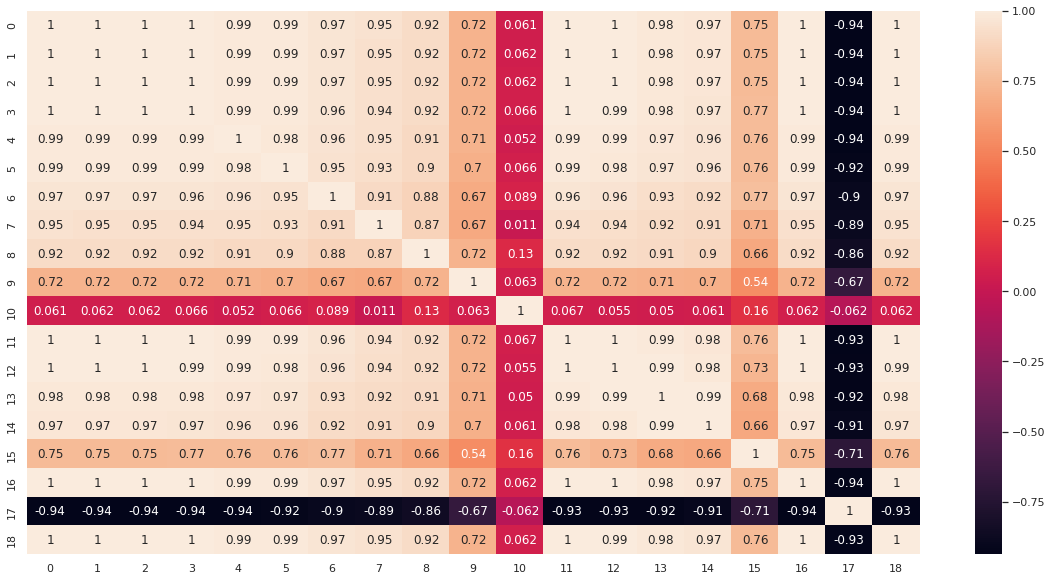

In [64]:
x, y = preprocessing(5, 16)

# Plot a correlation matrix to determine if there are any redundancies
corr = pd.DataFrame(x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, 
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 annot=True)

## Machine Learning Pipeline

In [65]:
%%capture
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [66]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [67]:
# This function prepares the x and y data for training by performing the test-train split, 
# and applying StandardScaler to normalize the values. The scaler is saved as a global
# variable so that it can be used to obtain the original data by performing inverse_transform
# (if needed)
def prep_for_training(x, y, scale_config = True):
    '''
    Prepares the features and labels for applying to machine learning models.
    Features are split into testing and training subsets and then scaled using
    StandardScaler.

    Arguments:
    x -- numpy array, contains features
    y -- numpy array, contains labels
    scale_config -- bool, if True, redefines the scaler and fits it to the training data, 
                    which is a subset of "x" created by the train_test_split function.
    
    Returns:
    train -- list, contains the training data consisting of features and corresponding labels
    test -- list, contains the testing data consisting of features and corresponding labels
    
    Additional:
    scaler is a global variable and can be used in later steps in case the original data 
    needs to be extracted, by running scaler.inverse_transform()
    '''
    global scaler
    
    # Split the data in the ratio 80:20 for training, testing respectively
    train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8)

    if scale_config:
        # Standardize the training data
        scaler = StandardScaler()
        # Fit the scaler to X_train
        scaler.fit(train_x)

    # Transform the entire data using the computed mean and variance
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    train = [train_x, train_y]
    test = [test_x, test_y]
    
    return train, test

We use **Principal Components Analysis (PCA)** to reduce the dimensionality of the features, retaining as much variability as possible. We use the minimum number of components necessary to retain 1% of standard deviation.

8 components are sufficient to satisfy the RMSE reconstruction criterion


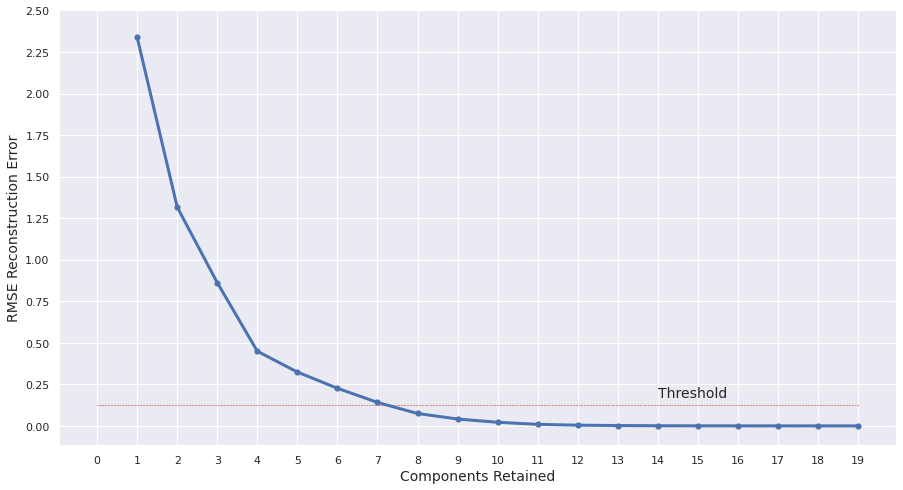

In [68]:
x, y = preprocessing(5, 16)     # using cell 5 for training
[train_x, train_y], [test_x, test_y] = prep_for_training(x, y)

# Import the module for PCA
from sklearn.decomposition import PCA

# Re-centre the data to have zero mean
X_for_pca = train_x - np.mean(train_x, axis=0)[np.newaxis, :]

# Compute std. deviation of L2 norm input vectors
l2_norm = np.sum(X_for_pca ** 2, axis=-1)
std_dev = np.std(l2_norm)

# Threshold for dimensionality reduction set to 1% of std. deviation
threshold = 0.01 * std_dev

rmse_vs_components = []   # List of RMSE vs n_components for plotting
desired_components = 19   # Start by assuming all components are necessary

# Iterate over number of retained dimensions
for n_components in range(1, 20):
    pca = PCA(n_components=n_components)

    # Fit PCA onto the input data
    pca.fit(X_for_pca)

    # Apply dimensionality reduction on X
    X_transformed = pca.transform(X_for_pca)

    # Transform back to the starting space to compute reconstruction error
    X_projected = pca.inverse_transform(X_transformed)

    # Compute RMSE reconstruction error
    rmse = np.sum((X_for_pca - X_projected) ** 2, axis=-1).mean()

    if rmse < threshold:
        desired_components = min(n_components, desired_components)

    rmse_vs_components.append(rmse)

# Plot RMSE vs Components Retained
plt.figure(figsize=(15, 8))
plt.xlabel('Components Retained', fontsize=14)
plt.ylabel('RMSE Reconstruction Error', fontsize=14)
plt.plot(np.arange(1, 20), rmse_vs_components, lw=3)
plt.scatter(np.arange(1, 20), rmse_vs_components, lw=3, s = 10)
plt.scatter(np.linspace(0,19,500),[threshold for i in range(500)], s = 0.05, color = 'r')
plt.text(14, threshold + 0.05, "Threshold", fontsize = 14)

plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0,2.75,0.25))

print(red(f"{desired_components}", 'bold'), "components are sufficient to satisfy the RMSE reconstruction criterion")

We use the obtained features after PCA to transform both the train and test data.

In [69]:
n_components = desired_components # Sufficient dimensions after compression

# PCA with 8 retained dimensions
pca = PCA(n_components=n_components)
pca.fit(X_for_pca)

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# Print the shape for confirmation
print(train_x.shape)
print(test_x.shape) 

(134, 8)
(34, 8)


We train the following models:
1. Support Vector Regressor (SVR): <br>
In contrast to normal Linear Regression, where the objective function is 
$$ min\sum_{i = 1}^{n} (y_i - w_i x_i) $$
the objective function of SVR is to minimize the the $l_2$ - norm of the coefficient vector — not the squared error.  The error term is instead handled in the constraints, where we set the absolute error less than or equal to a specified margin, which we denote by ɛ. The objective function hence becomes 
$$ min\;{\vert\vert w \vert\vert}^2 $$
subject to the constraint 
$$ \vert y_i - w_i x_i \vert < ɛ $$ 
<br>
2. Multilayered Perceptron (MLP): <br>
Multilayered Perceptrons consist of an input and output *layer* with several possible *hidden layers*. A simple MLP with one hidden layer is shown below.<br>
<img align="center" src="https://images.deepai.org/glossary-terms/multilayer-perceptron-799207.jpg"><br>
After applying the activation function of each hidden layers, the hidden layer's output is calculated by computing the dot product between the previous layer's output and the weights of the current hidden layer. This is continued till the output layer is reached. During training the output will be used for the *backpropogation* algorithm to reduce the calculated loss depending on the selected criterion. During testing the output is used as is. <br>

3. Random Forest Regressor: <br>
Random Forests use Ensemble Learning for regression/classification purposes. Several decision trees are trained and their individual predictions are pooled to obtain much more accurate results compared to a single tree. In regression tasks, the output of the model is a mean of the predictions of all decision trees.
<br>
The following four algorithms belong to a family of *Boosting algorithms*. Boosting is an ensemble modelling technique that attempts to build a robust classifier from the number of weak classifiers. It is done by building a model by using weak models in series. Firstly, a model is built from the training data. Then the second model is built, which tries to correct the errors present in the first model. This procedure continues, and models are added until the complete training data set is predicted correctly or the maximum number of models are added.<br>
<img align="center" src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528107577/output_1_0_ilvuyr.png">
4. XGBoost Regressor: <br>
XGBoost (or eXtreme Gradient Boosting) is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting algorithm. 
<br>
5. AdaBoost Regressor: <br>
AdaBoost (or Adaptive Boosting) was the first succesful approach for implementing the Boosting algorithm. The AdaBoost algorithm involves using very short (one-level) decision trees as weak learners that are added sequentially to the ensemble.
<br>
6. LightBGM Regressor: <br>
LightBGM (or Light Boosted Gradient Machine) extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This results in a dramatic speedup of training and improved predictive performance.
<br>
7. CatBoost Regressor: <br>
CatBoost is an open-source library developed by Yandex. It is a depth-wise gradient boosting library which uses oblivious decision trees to grow a balanced tree.
<br>

In [70]:
# These functions train and evaluate their respective models. Models are saved as 
# global variables so they can be used in the later step of evaluating the model.
# Evaluataion is carried out on completely different cells which the model has not seen

def eval_svr(train, test, training = True):
    '''
    If training is enabled, a new instance of a Support Vector Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global svr

    if training:
        # Define a SVM regressor with a Gaussian kernel
        svr = SVR()

        # Train the model
        svr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(svr.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_mlp(train, test, training = True, layer_size = 100, max_iter = 100):
    '''
    If training is enabled, a new instance of a Multi Layered Perceptron model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global mlp
    
    if training: 
        # Define a regressor with 1 hidden layer
        mlp = MLPRegressor(hidden_layer_sizes = (layer_size,), max_iter = max_iter)
        # Train the model
        mlp.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(mlp.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_rf(train, test, training = True, n_estimators = 100):
    '''
    If training is enabled, a new instance of a Random Forest Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global regressor
    
    if training:
        # Define a random forest regressor
        regressor = RandomForestRegressor(n_estimators = n_estimators)
        # Train the model
        regressor.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(regressor.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_xgb(train, test, training = True):
    '''
    If training is enabled, a new instance of an XGBoost Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global xgbr
    
    if training:
        # Define a xgb regressor
        xgbr = XGBRegressor()
        # Train the model
        xgbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = xgbr.predict(test[0])
    print(blue(f"Evaluating the XGBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_abr(train, test, training = True):
    '''
    If training is enabled, a new instance of an AdaBoost Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global abr
    
    if training:
        # Define a adaboost regressor
        abr = AdaBoostRegressor()
        # Train the model
        abr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = abr.predict(test[0])
    print(blue(f"Evaluating the AdaBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_lgbmr(train, test, training = True):
    '''
    If training is enabled, a new instance of a Light GBM Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global lgbmr

    if training:
        # Define a LightBGM regressor
        lgbmr = LGBMRegressor()
        # Train the model
        lgbmr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = lgbmr.predict(test[0])
    print(blue(f"Evaluating the LightBGM Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_cbr(train, test, training = True):
    '''
    If training is enabled, a new instance of a Cat Boost Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global cbr
    
    if training:
        # Define a LightBGM regressor
        cbr = CatBoostRegressor()
        # Train the model
        cbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = cbr.predict(test[0])
    print(blue(f"Evaluating the CatBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [ ]:
train, test = [train_x, train_y], [test_x, test_y]

eval_svr(train, test, training = True)
eval_rf(train, test, training = True)
eval_xgb(train, test, training = True)
eval_abr(train, test, training = True)
eval_lgbmr(train, test, training = True)
eval_cbr(train, test, training = True)

In [72]:
# Using an Artificial Neural Network with LSTM and Dense layers
# Importing required libraries
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

def create_model(plot = False, dpi = 96):
    '''
    Returns an Artificial Neural Network model made for regression tasks

    Arguments:
    plot -- bool, specifies whether the model visualization plot should be 
            displayed
    dpi -- integer, if plot = True, specifies the dots-per-inch for the model
           plot image

    Returns:
    model -- a compiled ANN built for regression tasks.
    '''
    inputs = Input(shape = (8,1), name = 'Input_features')
    lstm = LSTM(32, input_shape = (8,1))(inputs)
    dense2 = Dense(10)(lstm)
    output = Dense(1, name = 'Output_Layer')(dense2)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    if plot: 
        print("Visualizing the model and its layers :")
        display(plot_model(model, show_shapes = True, dpi = dpi))

    return model

def eval_nn(train, test, training = True, plot = True, dpi = 96, ncols = None):
    '''
    If training is enabled, a new instance of an Artificial Neural Network model is created
    and fit on the training data. The model is then fed with test data and it's performance 
    is reported. If training is disabled, the model previously defined is simply evaluated 
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled
    plot -- bool, specifies whether the model visualization plot should be displayed
    dpi -- integer, if plot = True, specifies the dots-per-inch for the model
           plot image
    ncols -- integer, specifies number of columsn for the training progress bar

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False"). 
    '''
    global nn
    
    if training: train_x = train[0].reshape(-1,8,1)
    test_x = test[0].reshape(-1,8,1)

    if training:
        # Define a LightBGM regressor
        nn = create_model(plot = True, dpi = dpi)
        # Train the model
        nn.fit(train_x, train[1], 
          epochs = 100, 
          batch_size = 1, 
          verbose = 0, 
          callbacks = [TqdmCallback(verbose = 0, ncols = ncols)])

    # Test the model returning mean accuracy
    y_pred = nn.predict(test[0])
    print(blue(f"Evaluating the Artificial Neural Network...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    rmse = np.sqrt(nn.evaluate(test_x, test[1]))
    print(f"RMSE = {rmse:.4f}")

Visualizing the model and its layers :


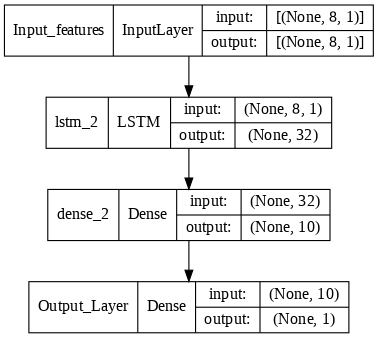

0epoch [00:00, ?epoch/s]

Evaluating the Artificial Neural Network...
R2 Score = 0.9935
2/2 [==============================] - 1s 9ms/step - loss: 2.1577e-04
RMSE = 0.0147


In [73]:
eval_nn(train, test, training = True, plot = True, dpi = 80)

### Model Evaluation
We have trained the models on battery #5 but test its generalisation capabilities by testing it on data from other batteries.

In [74]:
# This function applies the previously trained models to the data of other cells
# which have not been used for the training process

def evaluate_cell(cell_number, model_type, axes, position):
    '''
    Evaluates the models of specified type on the data corresponding
    to the specified cell number. Data is first extracted and processed and then
    fed to the model of specified type for evaluation. The results are printed
    and a plot of predicted vs true labels is also created.

    Arguments: 
    cell_number -- integer, should be one of 5, 6, 7, 18
    model_type -- should be one of "lgbmr", "rf", "nn" or "all"
    axes -- matplotlib axes objects, plots will be arranged on these pre-defined axes
    position -- tuple, the plot will be arranged in the position specified by this argument. 

    If model_type = "all" then all models, i.e. lgbmr, rf and nn 
    are evaluated using the data from the specified cell number and a
    single plot containing predicted labels vs true labels is created.
    Models are evaluated using the corresponding evaluate functions 
    after setting training to False.
    '''
    x, y = preprocessing(cell_number, 16)
    x = scaler.transform(x)
    x = pca.transform(x)

    #plt.figure(figsize = (10,5))
    
    if model_type == 'lgbmr' or model_type == 'all': 
        eval_lgbmr(_, [x, y], training = False)
        axes[position[0], position[1]].plot(lgbmr.predict(x), label = "LightGBM Regressor")
    
    if model_type == 'rf' or model_type == 'all':
        eval_rf(_, [x, y], training = False)
        axes[position[0], position[1]].plot(regressor.predict(x), label = "Random Forest Regressor")
    
    if model_type == 'nn' or model_type == 'all':
        eval_nn(_, [x, y], training = False, plot = False)
        axes[position[0], position[1]].plot(nn.predict(x.reshape(-1,8,1)), label = "Artificial Neural Network")
    
    axes[position[0], position[1]].plot(y.reshape(-1,1), label = "True labels")
    axes[position[0], position[1]].legend()
    axes[position[0], position[1]].set_xlabel("Cycles", fontsize = 14)
    axes[position[0], position[1]].set_ylabel("Capacity of the battery (Ahr)", fontsize = 14)

Applying the previously trained models to data from cell 7
Evaluating the LightBGM Regressor...
R2 Score = 0.9745
RMSE = 0.0256
Evaluating the Artificial Neural Network...
R2 Score = 0.9731
6/6 [==============================] - 0s 5ms/step - loss: 6.9299e-04
RMSE = 0.0263
Evaluating the Random Forest Regressor...
R2 Score = 0.9726
RMSE = 0.0265
Comparing all models at once
Evaluating the LightBGM Regressor...
R2 Score = 0.9745
RMSE = 0.0256
Evaluating the Random Forest Regressor...
R2 Score = 0.9726
RMSE = 0.0265
Evaluating the Artificial Neural Network...
R2 Score = 0.9731
6/6 [==============================] - 0s 4ms/step - loss: 6.9299e-04
RMSE = 0.0263


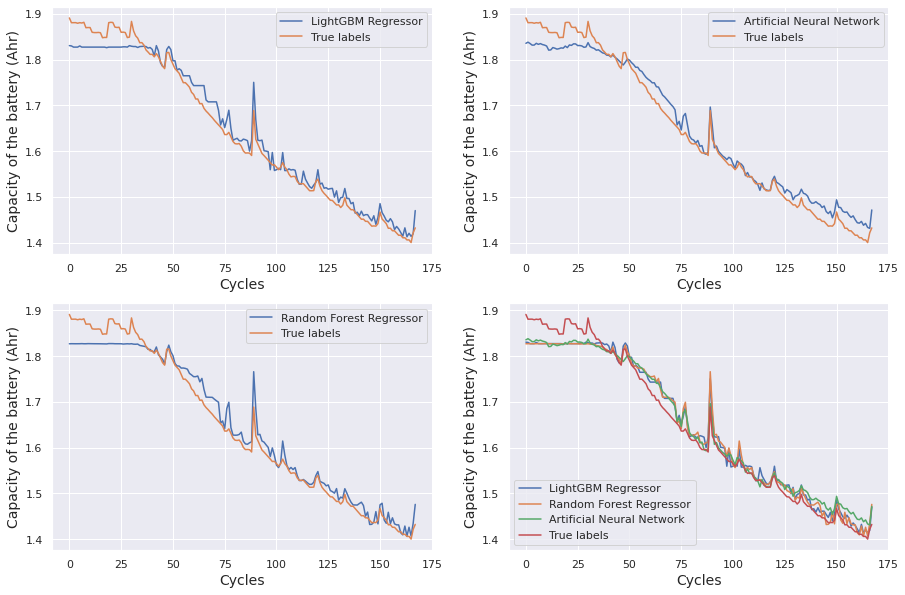

In [78]:
print(red("Applying the previously trained models to data from cell 7", 'bold'))
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

evaluate_cell(7, 'lgbmr', axes, (0,0))
evaluate_cell(7, 'nn', axes, (0,1))
evaluate_cell(7, 'rf', axes, (1,0))

print(red("Comparing all models at once", 'bold'))
evaluate_cell(7, 'all', axes, (1,1))

### Model Explainability

We want to understand why our model is predicting what it predicts. For this purpose, we try to understand the importance of each feature in predicting capacity. We start by making Partial Dependence Plots (PDPs) for each feature which assumes that the other features are held constant. 

In [53]:
from sklearn.inspection import PartialDependenceDisplay

def partial_dependence_plot(model, feature, ax, data = train[0]):
    '''
    Plots a partial dependance plot for the specified feature using the specified model.

    Arguments:
    model -- regression model, should be one of the models defined in the above cells
    feature -- list, contains the features for which the partial dependence plot will
               be made
    ax -- matplotlib axis object, axis or position where the plot will be made
    '''

    display = PartialDependenceDisplay.from_estimator(
    model,
    data,
    feature,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
    )
    display.axes_[0][0].set_xlabel(f"Feature {feature}", fontsize=14)
    display.axes_[0][0].set_ylabel("Partial Dependence", fontsize=14)

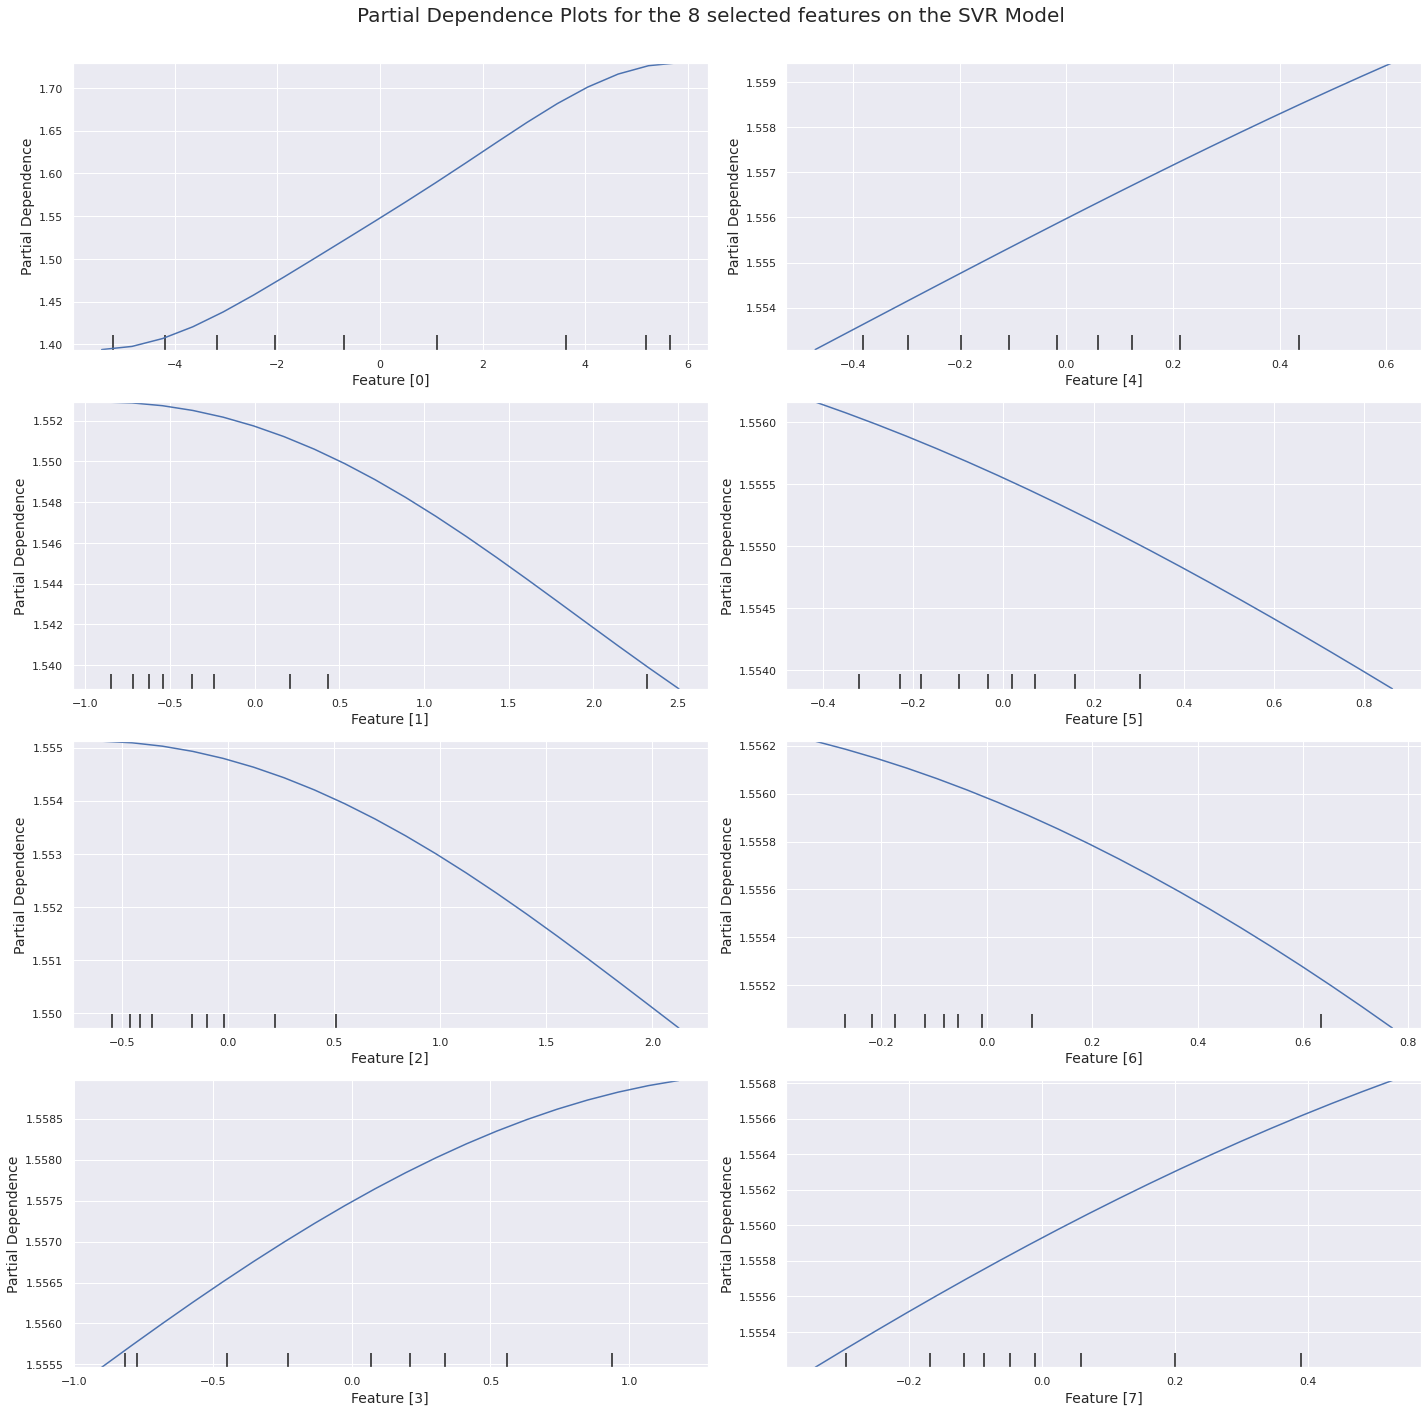

In [54]:
features = {0: [[i] for i in range(4)],
            1: [[i] for i in range(4,8)]}

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the SVR Model \n", fontsize=20)

for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(svr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(svr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

Computing partial dependence plots...
Computing partial dependence plots...
Computing partial dependence plots...
Computing partial dependence plots...
Computing partial dependence plots...
Computing partial dependence plots...
Computing partial dependence plots...
Computing partial dependence plots...


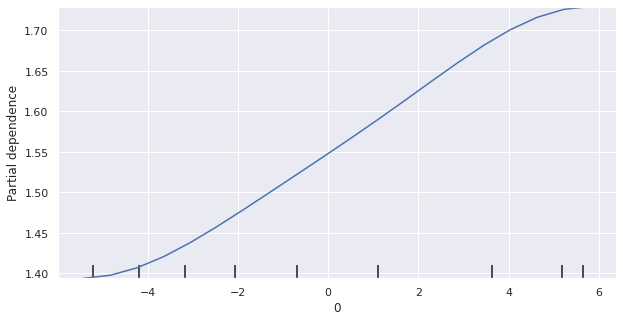

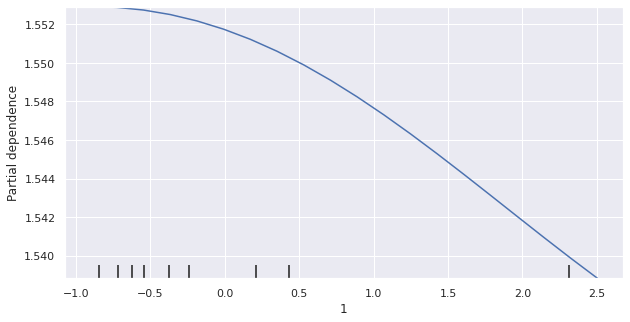

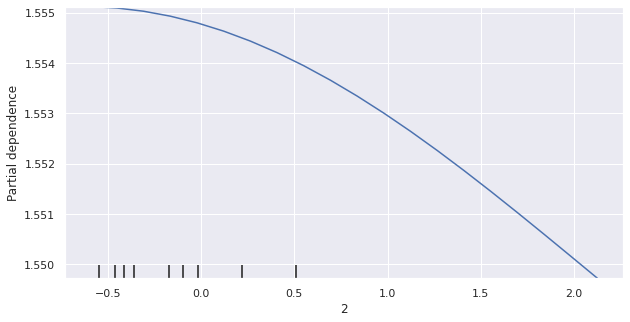

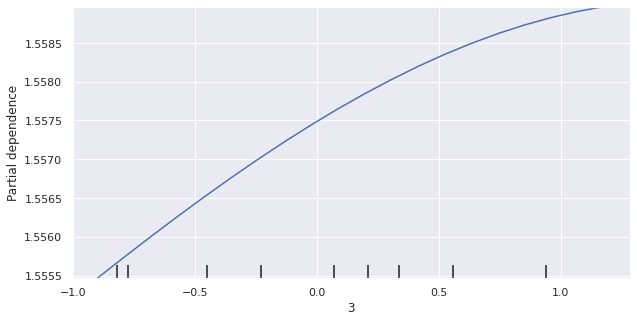

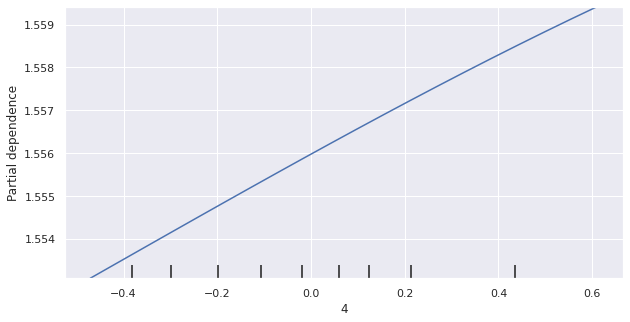

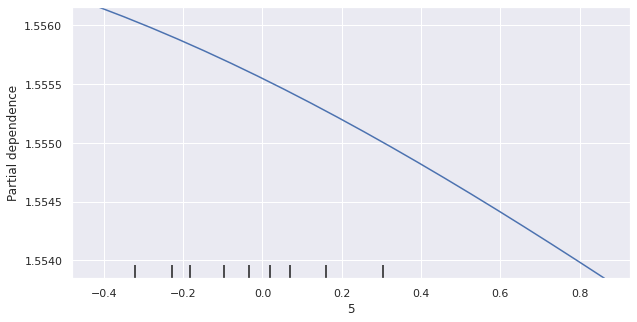

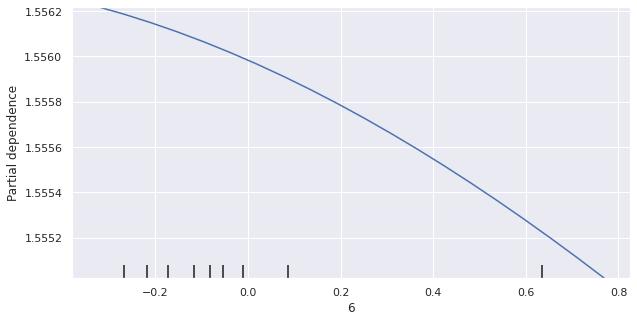

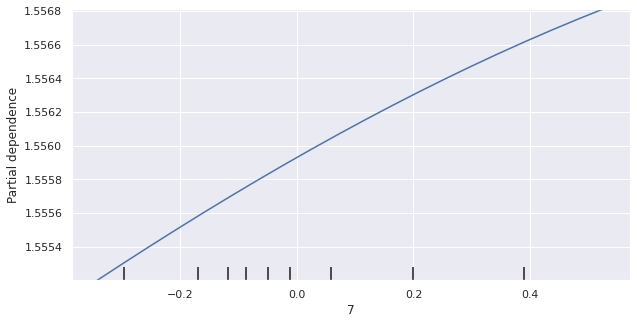

In [55]:
from sklearn.inspection import PartialDependenceDisplay

features = [0]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [1]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [2]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [3]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [4]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [5]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [6]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features = [7]
print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=1, figsize=(10, 5))
display = PartialDependenceDisplay.from_estimator(
    svr,
    train[0],
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)